# Introdução

Nesse notebook temos a análise descritiva dos dados. O objetivo dessa análise será obtermos hipóteses sobre o comportamento dos dados que nos ajudem a construir os modelos para a previsão das remessas para cada um dos clusters.

Primeiro iremos carregar e validar os dados para em seguida realizar.

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib
matplotlib.style.use('ggplot')

# Carregamento e análise preliminar dos dados

Para evitar o "vazamento" de informação dos dados de teste para a modelagem não iremos analisar os dados de teste. Essa é uma boa prática em modelagens supervisionadas e ajuda a garantir que quando estivermos aplicando o modelo aos dados de teste, estejamos em mais propício possível para testar a capacidade de generalização do modelo. Apensa consideraremos para a análise descritiva os dados de treinamento, localizados na planilha `Dados Históricos` do arquivo Excel. Ainda, para simplificar a análise, as variáveis de volume e dropsize serão desconsideradas. Dessa forma, iremos utilizar apenas as coluns `DataEntrega`, `Cluster`, e `Remessas`.

Junto aos dados originais, também é adicionada uma nova coluna indicando se o dia é um feriado. Os dados dos feriados são resgatados da planinha `Feriados Nacionais` de mesmo arquivo excel.

In [3]:
# carregando os dados de treinamento do arquivo excel
# para simplificar a análise iremos utilizar apenas a variável remessa
# a variável volume será descartada, e dropsize consequentemente 
# dropsize não agrega nenhuma informação nova uma vez que ela
# é a razão entre volume e remessas
df = pd.read_excel("Case.xlsx",
                   sheet_name="Dados Históricos",
                   usecols=["DataEntrega", "Cluster", "Remessas"])
# informacações gerais sobre o dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DataEntrega  3360 non-null   datetime64[ns]
 1   Cluster      3360 non-null   object        
 2   Remessas     3360 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 78.9+ KB


In [4]:
# olhando os primeiros registros
df.head()

,DataEntrega,Cluster,Remessas
0,2019-10-01,A,466
1,2019-10-01,B,5
2,2019-10-01,C,898
3,2019-10-01,D,159
4,2019-10-01,E,441


In [5]:
holiday_list = (pd.read_excel("Case.xlsx",
                              sheet_name="Feriados Nacionais",
                              usecols=["Datas"]).
                squeeze().to_list())
len(holiday_list)

14

In [6]:
df["Feriado"] = df["DataEntrega"].isin(holiday_list)

## Verificando os dados

Duas coisas precisam ser verificadas antes de seguirmos com a análise. A primeira, é a periodicidade dos dados. Isto é se os dados são diários, semanais ou mensais, e ainda, se para todos os diais referentes a data está compreendida nos dados. Em segundo lugar, se para todas as datas, todos os clusters possuem informações de remessas (mesmo se essa informação for 0).

In [7]:
# identificando quantas datas e quantos clusters
df[["DataEntrega", "Cluster"]].nunique()

DataEntrega    336
Cluster         10
dtype: int64

In [8]:
# verificando se temos a mesma exata quantidade de registro para cada cluster
assert (df["Cluster"].value_counts() == df["DataEntrega"].nunique()).all()

In [9]:
# identificando o começo e o fim do período
df["DataEntrega"].agg(["min", "max"]) 

min   2019-10-01
max   2020-08-31
Name: DataEntrega, dtype: datetime64[ns]

In [10]:
# identificando quais são os clusters únicos
df["Cluster"].unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'J', 'K', 'L', 'M'], dtype=object)

In [11]:
# identificando a periodicidade nos dados
df["DataEntrega"].drop_duplicates().sort_values().diff(1).dropna().value_counts()

1 days    335
Name: DataEntrega, dtype: int64

In [12]:
# verificando se a periodicidade diária é válida para todos os clusters
for cluster in df["Cluster"].unique():
    assert (df.loc[df["Cluster"] == cluster, "DataEntrega"].
            sort_values().diff(1).dropna() == pd.Timedelta(1, unit="days")).all()

Como é possível observar temos dados de remessas para 10 clusters distintos, de A a M, em 336 dias, de 01-10-2019 ao dia 31-08-2020. A frequência dos dados é diária, sendo preenchida diariamente para todos os clusters.

# Distribuição das remessas

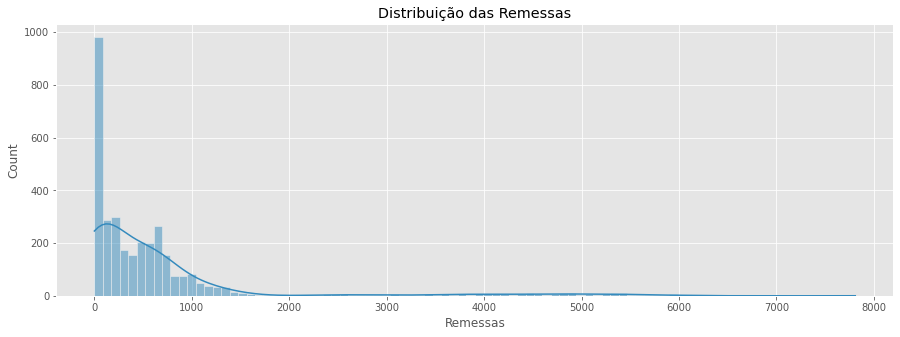

In [13]:
# analisando a distribuição das remessas com um histograma
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x="Remessas", bins=90, kde=True)
plt.title("Distribuição das Remessas")
plt.show()

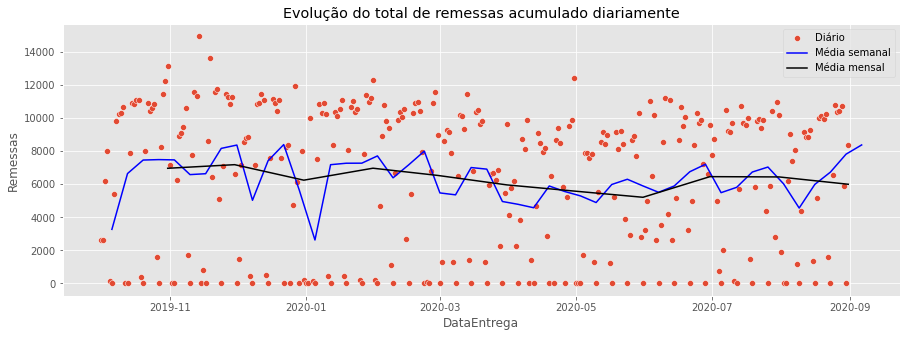

In [14]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=df.groupby("DataEntrega")["Remessas"].sum());
sns.lineplot(data=df.groupby("DataEntrega")["Remessas"].sum().resample("W").mean(), color="blue");
sns.lineplot(data=df.groupby("DataEntrega")["Remessas"].sum().resample("M").mean(), color="black");
plt.legend(["Diário", "Média semanal", "Média mensal"])
plt.title("Evolução do total de remessas acumulado diariamente")
plt.show()

In [15]:
# criando uma nova variável do dia da semana da data
# os rótulos dessa variável são em inglês
df["DiaNome"] = df["DataEntrega"].dt.day_name()

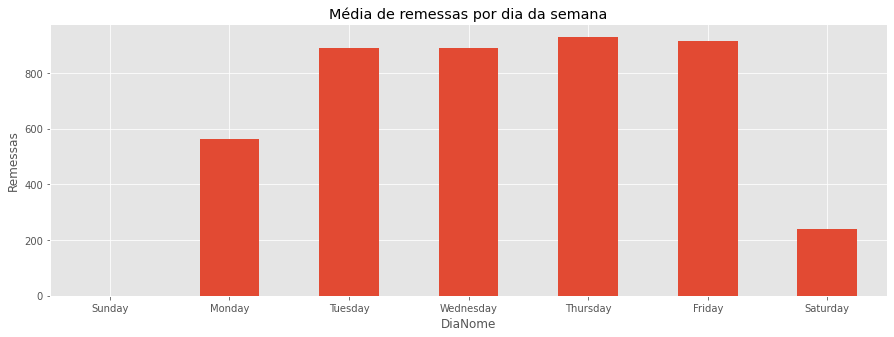

In [16]:
# definindo a ordem do eixo x
week_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
# gerando o gráfico de barras
(df.groupby("DiaNome")["Remessas"].
 mean().reindex(week_order).
 plot(kind="bar", figsize=(15, 5)))
# rotacionando os rótulos dos ticks do eixo x
plt.xticks(rotation=0)
# atribuindo título ao eixo y
plt.ylabel("Remessas")
# atribuindo título à figura
plt.title("Média de remessas por dia da semana")
plt.show()

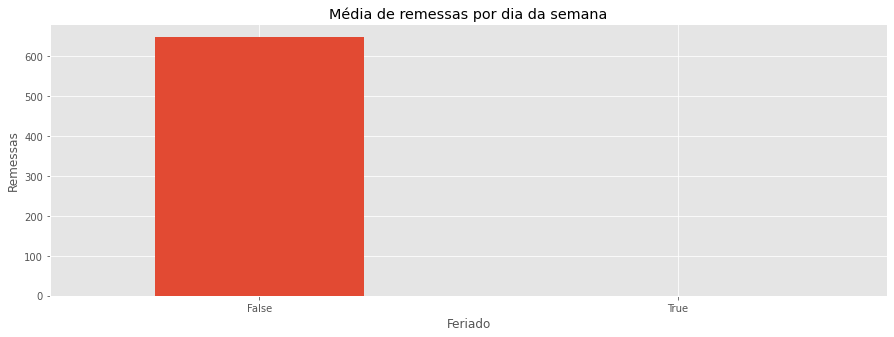

In [19]:
# gerando o gráfico de barras
(df.groupby("Feriado")["Remessas"].
 mean().plot(kind="bar", figsize=(15, 5)))
# rotacionando os rótulos dos ticks do eixo x
plt.xticks(rotation=0)
# atribuindo título ao eixo y
plt.ylabel("Remessas")
# atribuindo título à figura
plt.title("Média de remessas por dia da semana")
plt.show()

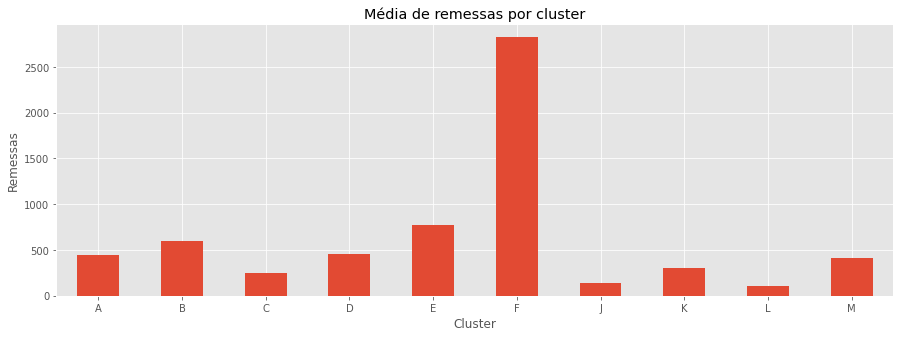

In [20]:
# gerando o gráfico de barras
(df.groupby("Cluster")["Remessas"].
 mean().plot(kind="bar", figsize=(15, 5)))
# rotacionando os rótulos dos ticks do eixo x
plt.xticks(rotation=0)
# atribuindo título ao eixo y
plt.ylabel("Remessas")
# atribuindo título à figura
plt.title("Média de remessas por cluster")
plt.show()

Cluster - A


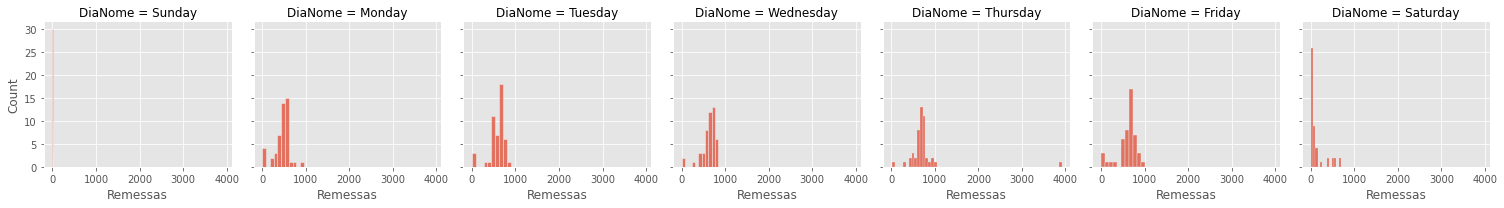

Cluster - B


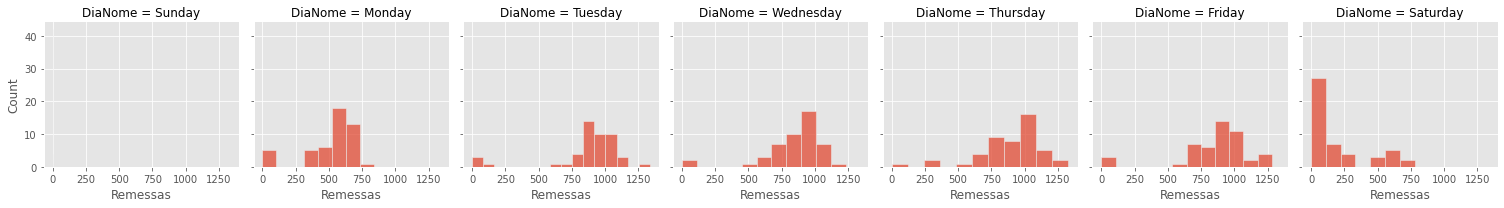

Cluster - C


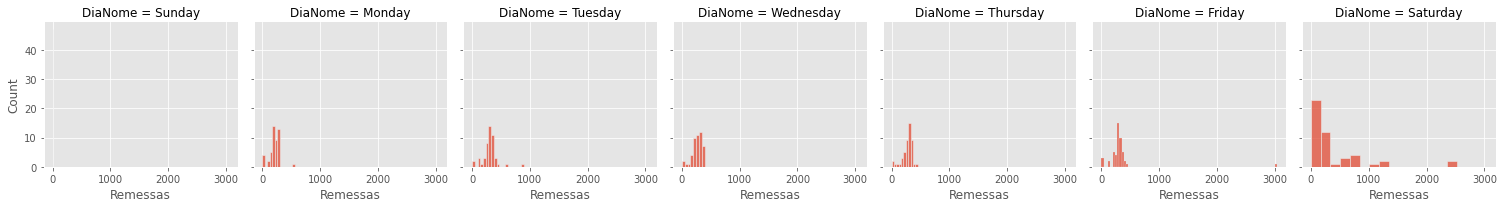

Cluster - D


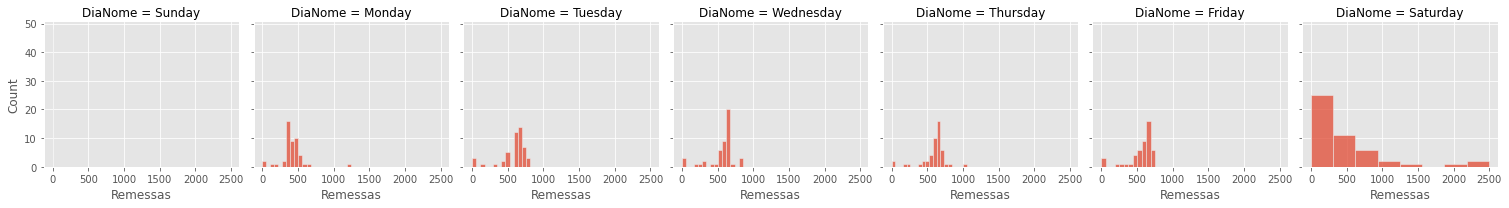

Cluster - E


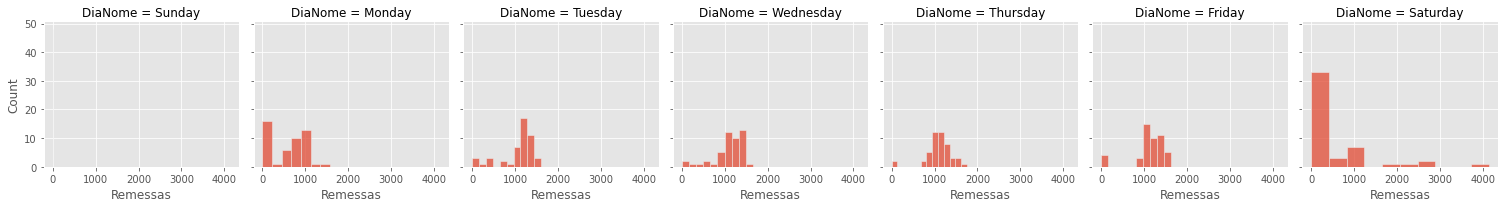

Cluster - F


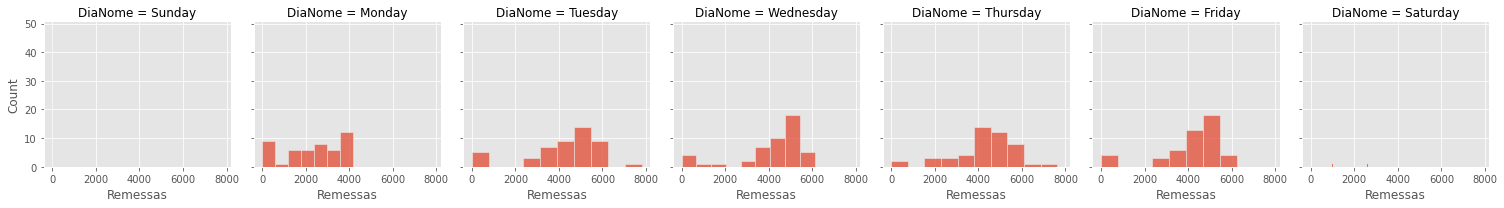

Cluster - J


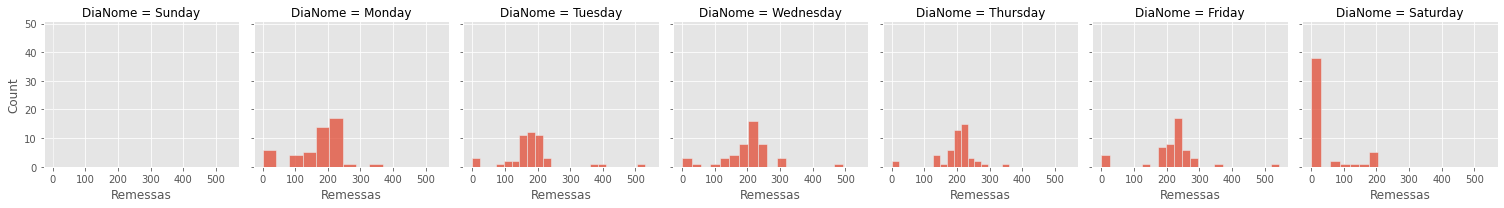

Cluster - K


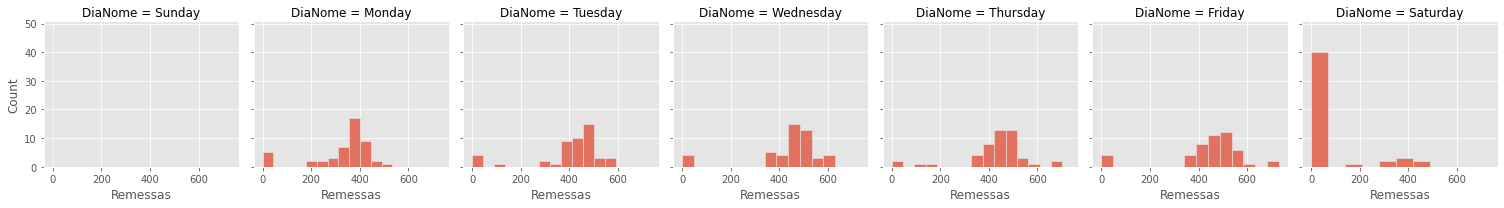

Cluster - L


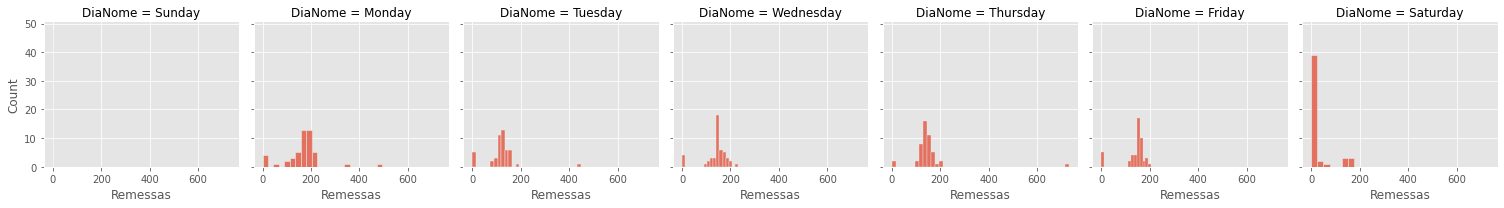

Cluster - M


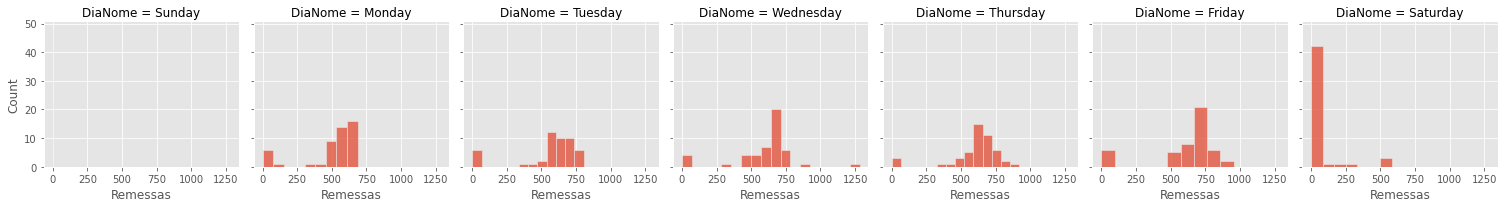

In [22]:
for cluster in df["Cluster"].unique():
    print(f"Cluster - {cluster}")
    cluster_mask = df["Cluster"] == cluster
    selected_df = df.loc[cluster_mask]
    g = sns.FacetGrid(selected_df, col="DiaNome", col_order=week_order)
    g.map_dataframe(sns.histplot, x="Remessas")
    plt.show()

In [31]:
weekend_mask = df["DiaNome"].isin(["Saturday", "Sunday"])
df["DayOff"] = weekend_mask | df["Feriado"]
df.groupby("DayOff")["Remessas"].mean()

DayOff
False    858.317094
True     113.389216
Name: Remessas, dtype: float64

Cluster - A


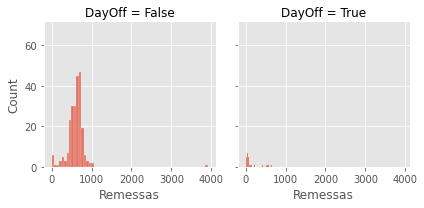

Cluster - B


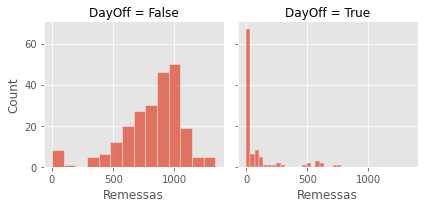

Cluster - C


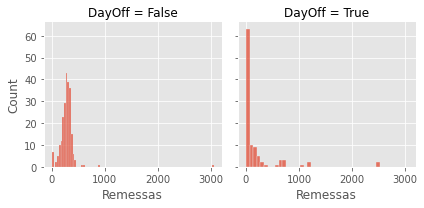

Cluster - D


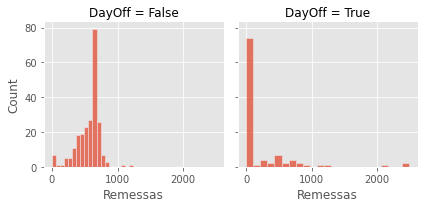

Cluster - E


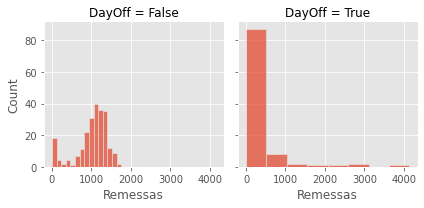

Cluster - F


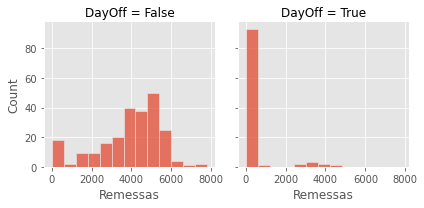

Cluster - J


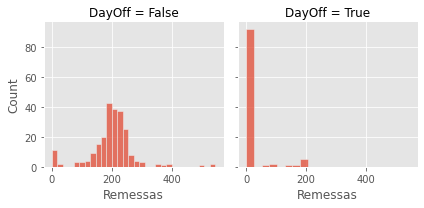

Cluster - K


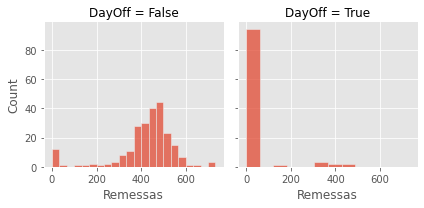

Cluster - L


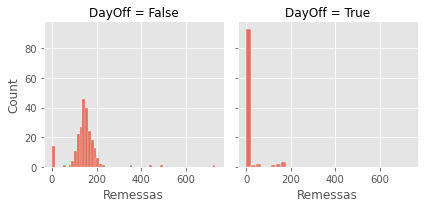

Cluster - M


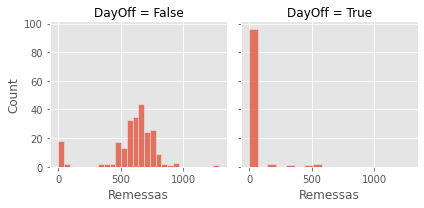

In [32]:
for cluster in df["Cluster"].unique():
    print(f"Cluster - {cluster}")
    cluster_mask = df["Cluster"] == cluster
    selected_df = df.loc[cluster_mask]
    g = sns.FacetGrid(selected_df, col="DayOff")
    g.map_dataframe(sns.histplot, x="Remessas")
    plt.show()